# Creating a Bell state with cross-resonance pulses on OQC's Lucy

In this notebook we will investigate cross-resonance mechanisms to create a Bell state, i.e., the `Hello world!` example in quantum computing. 

The simplest circuit to generate a Bell pair is an Hadamard gate on a first qubit followed by a CNOT gate between this qubit and a second qubit. However, diving deeper in the pulse implementation of such gates, we would realize that they require specific mechanisms that are tightly connected to the hardware type and device architecture. Focusing on the capabilities of OQC's Lucy device, we will replace the canonical CNOT gate with a different entangling gate that is either the cross-resonance (CR) gate or its echoed version. We will then see how two qubits interact when we drive one qubit at the frequency of the other and calibrate this process to be able to create a Bell pair.

In [ ]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

Let's first start with importing some packages as usual.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from braket.aws import AwsDevice
from braket.pulse import PulseSequence, ConstantWaveform

from braket.circuits import Circuit, Observable
from braket.parametric import FreeParameter


We will use two qubits, #0 amd #1, that are physically connected to each other. We also instantiate an OQC device to extract frames and submit circuits.

In [2]:
a=0
b=1

device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")

## Bell pair with the H, ECR and V gates

First we show how to transform the canonical Bell state circuit into another one where we replace the CNOT gate by an echoed cross-resonance (ECR) gatet and a V gate, also known as SX (square-root of X). These gates are native on the Lucy device.

As shown in Phys. Rev. B. 81, 134507 (2010) and Phys. Rev. Applied 12, 064013, the ECR gate implements an unitary evolution of the system that can be decomposed in two steps with a time reversal half way through the process to suppress most undesired evolution.
$$ R_{ZX}(\pi/4)-R_X(\pi)-R_{ZX}(\pi/4).$$
The $R_{ZX}$ is interpretable as the rotation of the second qubit, conditioned by the state of the first qubit. 

In [3]:
bell_pair_with_gates = Circuit().h(a).ecr(a, b).v(b)
print(bell_pair_with_gates)

T  : |0| 1 |2|
              
q0 : -H-ECR---
        |     
q1 : ---ECR-V-

T  : |0| 1 |2|


The circuit is then executed on the OQC device and we plot the measurement histogram which indicates that we created $$\frac{|00\rangle+e^{i\phi}|11\rangle}{\sqrt{2}}$$

Text(0, 0.5, 'Population')

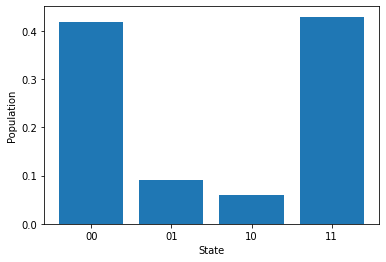

In [4]:
nb_shots = 100
task = device.run(bell_pair_with_gates, shots = nb_shots)
counts = task.result().measurement_counts


plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

## Bell pair with the pulse implementation of the cross-resonance sequence

Instead of tackling the implementation of the complete echoed cross resonance pulse sequence, we use a simple cross-resonance (CR) gate. The CR gate is a single-pulse gate that implements the unitary transformation $$ \exp(−i \beta Z X / 2),$$ where Z and X are the 2x2 Pauli matrices. Practically, you can understand the gate by isolating its action for each eigenstate of the control qubit. If it is in $|0\rangle$ (resp. $|1\rangle$), the target qubit undergoes a rotation of angle $\beta$ (resp. $-\beta$). 

We seek to measure the interaction strength between the qubits when we drive one of them at the frequency of the other. For this, we use the frame `q0_q1_cross_resonance` that is bound to qubit 0 but tuned up to the frequency of qubit 1. As we will test this pulse sequence in a quantum circuit containing single-qubit gates on other qubits, we also declare the 1-qubit drive frames for 0 and 1. 

In [5]:
q0_q1_CR = device.frames[f'q{a}_q{b}_cross_resonance']
q0 = device.frames[f'q{a}_drive']
q1 = device.frames[f'q{b}_drive']

The sequence consists of a single square pulse of amplitude 0.18. This value has been determined by running the circuits below for different amplitudes and choosing the one that optimizes the difference of the expectation values $\langle IZ \rangle$ taken for the opposite initialization of the control qubit.

In [6]:
length = FreeParameter("length")
const_wf = ConstantWaveform(length, 0.18)

cross_resonance_sequence = (
    PulseSequence()
    .barrier([q0, q1, q0_q1_CR])
    .play(q0_q1_CR, const_wf)
    .barrier([q0, q1, q0_q1_CR])
)

We run two batches of circuits where we vary the length of the pulse from 12ns to 1.4 µs. Each batch has a different initialized state: $|0\rangle$ for the first, $|1\rangle$ for the second. 

In [7]:
lengths = np.arange(12e-9, 1.5e-6, 36e-9)
nb_shots = 1000

# Initialization of the control qubit in 0
circuit = (
    Circuit()
    .pulse_gate([0, 1], pulse_sequence=cross_resonance_sequence)
    .expectation(observable = Observable.I() @ Observable.Z(),target=[0,1])
)
CR_circuits = [circuit(length=l) for l in lengths]
batch_init_0 = device.run_batch(CR_circuits, shots=nb_shots, disable_qubit_rewiring=True)

# Initialization of the control qubit in 1
circuit = (
    Circuit()
    .x(0)
    .pulse_gate([0, 1], pulse_sequence=cross_resonance_sequence)
    .expectation(observable = Observable.I() @ Observable.Z(),target=[0,1])
)
CR_circuits = [circuit(length=l) for l in lengths]
batch_init_1 = device.run_batch(CR_circuits, shots=nb_shots, disable_qubit_rewiring=True)

We analyze the data by plotting the expectation value $\langle IZ \rangle$ versus the pulse duration for each batch. 

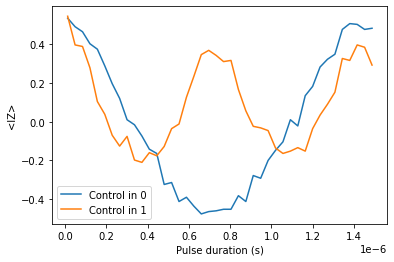

In [8]:
IZ_exp_value_init_0 = np.array([result.values[0] for result in batch_init_0.results()])
IZ_exp_value_init_1 = np.array([result.values[0] for result in batch_init_1.results()])

plt.plot(lengths, IZ_exp_value_init_0, label="Control in 0")
plt.plot(lengths, IZ_exp_value_init_1, label="Control in 1")
plt.xlabel("Pulse duration (s)")
plt.ylabel("<IZ>")
plt.legend()

The plot displays a state-dependent oscillatory behavior indicating that we have implemented a unitary evolution based on the ZX interaction. We see also from the previous plot that, for pulse duration of 700ns, the two qubits interacts long enough for the state of the target qubit (i) to be flipped if the control qubit is its ground state or (ii) to cycle back to the original state if the control is in the excited state. Adding an X gate after this sequence would give the expected for the CNOT gate. 

Fixing the duration of the pulse to this particular value, we can now create a circuit including our custom pulse sequence and create a Bell state

In [9]:
RZX_sequence = cross_resonance_sequence(length=700e-9)

bell_pair_with_pulses = (
    Circuit()
    .h(a)
    .pulse_gate([a ,b], pulse_sequence=RZX_sequence)
    .x(b)
)

We now can execute this circuit, which returns similar results as with the circuit using an ECR gate. 

We can however notice that the fidelity is worse than in the first case, due to the fact that we did not include any correction for crosstalks such as cross-resonant cancelation, pulse synchronization and an echo scheme. To dive deeper and investigate methods to improve these results, see the following paper Phys. Rev. Applied 12, 064013. 

Text(0, 0.5, 'Population')

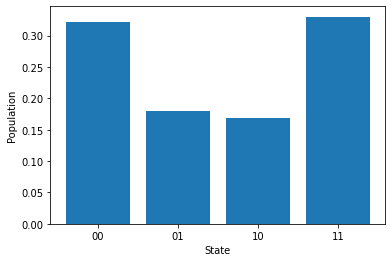

In [10]:
nb_shots = 500
task = device.run(bell_pair_with_pulses, shots = nb_shots)
counts = task.result().measurement_counts


plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

In [ ]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")